** LOGISTIC REGRESSION TO PREDICT HEART DISEASE.**

In [41]:
# Import des bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean, sum, max
from pyspark.sql.functions import when
from pyspark.sql.functions import col, count
import seaborn as sns
import pandas as pd

In [42]:
# Création d'une session Spark
spark = SparkSession.builder \
    .appName("Regression logistique avec PySpark") \
    .getOrCreate()

# Chargement des données
heart_df = spark.read.format("csv").option("header", "true").load("input/framingham.csv")

# Renommage de la colonne 'male' en 'Sex_male'
heart_df = heart_df.withColumnRenamed("male", "Sex_male")

# Suppression des lignes avec des valeurs manquantes
heart_df = heart_df.dropna()
# Supprimer les lignes contenant des NaN
heart_df = heart_df.na.drop()

# Visualisation

In [43]:
heart_df.toPandas().head()

,Sex_male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0,0,0,0,0,195,106,70,26.97,80,77,0
1,0,46,2,0,0,0,0,0,0,250,121,81,28.73,95,76,0
2,1,48,1,1,20,0,0,0,0,245,127.5,80,25.34,75,70,0
3,0,61,3,1,30,0,0,1,0,225,150,95,28.58,65,103,1
4,0,46,3,1,23,0,0,0,0,285,130,84,23.1,85,85,0


In [44]:
heart_df.count()

4238

In [45]:
heart_df.groupBy('Sex_male').count().show()

+--------+-----+
|Sex_male|count|
+--------+-----+
|       0| 2419|
|       1| 1819|
+--------+-----+



### Distribution de la maladie CHD selon le sex

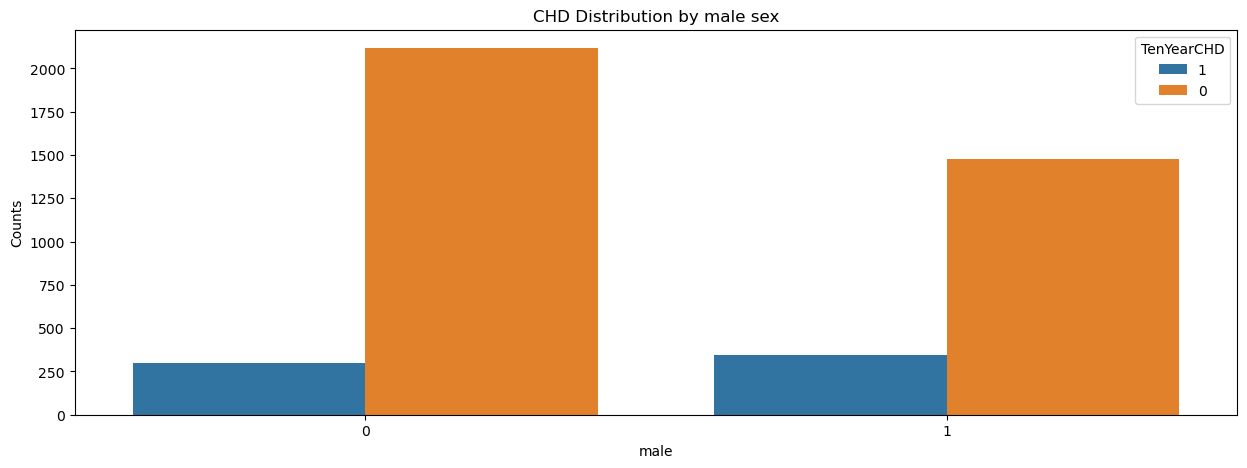

In [46]:
sex_chd_count = (heart_df.groupBy(['Sex_male','TenYearCHD'])
                    .agg(count(col('Sex_male')).alias('count'))
                    .toPandas())

fig, ax = plt.subplots(1, 1, figsize=(15,5))

# graphique à barres
sns.barplot(x='Sex_male', y='count', hue='TenYearCHD', data=sex_chd_count)

plt.xlabel('male')
plt.ylabel('Counts')
plt.title('CHD Distribution by male sex')

plt.show()

In [47]:
heart_df.groupBy('TenYearCHD').count().show()

+----------+-----+
|TenYearCHD|count|
+----------+-----+
|         0| 3594|
|         1|  644|
+----------+-----+



## Vérification de la corrélation avec TenYearCHD 

In [48]:
import pyspark.sql.functions as F

correlations = heart_df.select([F.corr(F.col('TenYearCHD'), F.col(c)).alias(c) for c in heart_df.columns]).toPandas()
correlations = correlations.T*100
correlations

,0
Sex_male,8.842757
age,22.525610
education,-5.405896
currentSmoker,1.945627
cigsPerDay,5.788426
BPMeds,8.748858
prevalentStroke,6.180995
prevalentHyp,17.760273
diabetes,9.731651
totChol,8.218428


In [49]:
# Suppression de la colonne 'education'
heart_df = heart_df.drop("education")


In [50]:
heart_df.printSchema()

root
 |-- Sex_male: string (nullable = true)
 |-- age: string (nullable = true)
 |-- currentSmoker: string (nullable = true)
 |-- cigsPerDay: string (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: string (nullable = true)
 |-- prevalentHyp: string (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- totChol: string (nullable = true)
 |-- sysBP: string (nullable = true)
 |-- diaBP: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- TenYearCHD: string (nullable = true)



In [53]:
# Conversion des colonnes string en double
for col_name in ["age", "cigsPerDay", "totChol", "sysBP","diaBP", "glucose","TenYearCHD","prevalentHyp"]:
    heart_df = heart_df.withColumn(col_name, col(col_name).cast("double"))

# Indexation et encodage des colonnes catégorielles
indexer = StringIndexer(inputCol='Sex_male', outputCol='Sex_maleIndex')
indexed = indexer.fit(heart_df).transform(heart_df)

encoder = OneHotEncoder(inputCols=['Sex_maleIndex'], outputCols=['Sex_maleIndexVec'])
encoded = encoder.fit(indexed).transform(indexed)


In [54]:
encoded.printSchema()

root
 |-- Sex_male: string (nullable = true)
 |-- age: double (nullable = true)
 |-- currentSmoker: string (nullable = true)
 |-- cigsPerDay: double (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: string (nullable = true)
 |-- prevalentHyp: double (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- totChol: double (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: double (nullable = true)
 |-- TenYearCHD: double (nullable = true)
 |-- Sex_maleIndex: double (nullable = false)
 |-- Sex_maleIndexVec: vector (nullable = true)



In [55]:
# Assemblage des colonnes en un vecteur de caractéristiques
assembler = VectorAssembler(inputCols=["age", "Sex_maleIndexVec", "cigsPerDay", "totChol", "sysBP","diaBP", "glucose","prevalentHyp"], outputCol="features", handleInvalid="skip")
output = assembler.transform(encoded)
output


DataFrame[Sex_male: string, age: double, currentSmoker: string, cigsPerDay: double, BPMeds: string, prevalentStroke: string, prevalentHyp: double, diabetes: string, totChol: double, sysBP: double, diaBP: double, BMI: string, heartRate: string, glucose: double, TenYearCHD: double, Sex_maleIndex: double, Sex_maleIndexVec: vector, features: vector]

In [56]:
output.toPandas().head()

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Sex_maleIndex,Sex_maleIndexVec,features
0,1,39.0,0,0.0,0,0,0.0,0,195.0,106.0,70.0,26.97,80,77.0,0.0,1.0,(0.0),"[39.0, 0.0, 0.0, 195.0, 106.0, 70.0, 77.0, 0.0]"
1,0,46.0,0,0.0,0,0,0.0,0,250.0,121.0,81.0,28.73,95,76.0,0.0,0.0,(1.0),"[46.0, 1.0, 0.0, 250.0, 121.0, 81.0, 76.0, 0.0]"
2,1,48.0,1,20.0,0,0,0.0,0,245.0,127.5,80.0,25.34,75,70.0,0.0,1.0,(0.0),"[48.0, 0.0, 20.0, 245.0, 127.5, 80.0, 70.0, 0.0]"
3,0,61.0,1,30.0,0,0,1.0,0,225.0,150.0,95.0,28.58,65,103.0,1.0,0.0,(1.0),"[61.0, 1.0, 30.0, 225.0, 150.0, 95.0, 103.0, 1.0]"
4,0,46.0,1,23.0,0,0,0.0,0,285.0,130.0,84.0,23.1,85,85.0,0.0,0.0,(1.0),"[46.0, 1.0, 23.0, 285.0, 130.0, 84.0, 85.0, 0.0]"


In [57]:
# Sélection des colonnes à utiliser pour l'entraînement
model_df = output.select(['features','TenYearCHD'])
model_df.toPandas().head()

,features,TenYearCHD
0,"[39.0, 0.0, 0.0, 195.0, 106.0, 70.0, 77.0, 0.0]",0.0
1,"[46.0, 1.0, 0.0, 250.0, 121.0, 81.0, 76.0, 0.0]",0.0
2,"[48.0, 0.0, 20.0, 245.0, 127.5, 80.0, 70.0, 0.0]",0.0
3,"[61.0, 1.0, 30.0, 225.0, 150.0, 95.0, 103.0, 1.0]",1.0
4,"[46.0, 1.0, 23.0, 285.0, 130.0, 84.0, 85.0, 0.0]",0.0


## Entrainement du modèle

In [58]:
# Division des données en ensembles d'entraînement et de test
train_data, test_data = model_df.randomSplit([0.75, 0.25], seed=42)

# Construction du modèle de régression logistique
lr = LogisticRegression(featuresCol="features", labelCol="TenYearCHD")
lr_model = lr.fit(train_data)


In [59]:
# Prédiction sur l'ensemble de test
predictions = lr_model.transform(test_data)

# Affichage de la matrice de confusion et de la précision
confusion_matrix = predictions.select(F.col("TenYearCHD"), F.col("prediction")).groupBy(F.col("TenYearCHD"), F.col("prediction")).count().orderBy(F.col("TenYearCHD"), F.col("prediction"))
confusion_matrix.show()
accuracy = predictions.filter(predictions.TenYearCHD == predictions.prediction).count() / float(predictions.count())
print("Accuracy:", accuracy)

+----------+----------+-----+
|TenYearCHD|prediction|count|
+----------+----------+-----+
|       0.0|       0.0|  769|
|       0.0|       1.0|    3|
|       1.0|       0.0|  128|
|       1.0|       1.0|    9|
+----------+----------+-----+

Accuracy: 0.8558855885588559


In [37]:
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
y_true = predictions.select(F.col("TenYearCHD"))
y_true = y_true.toPandas()
y_true
y_pred = predictions.select(F.col("prediction"))
y_pred = y_pred.toPandas()


Confusion matrix, without normalization
[[  9 128]
 [  3 769]]


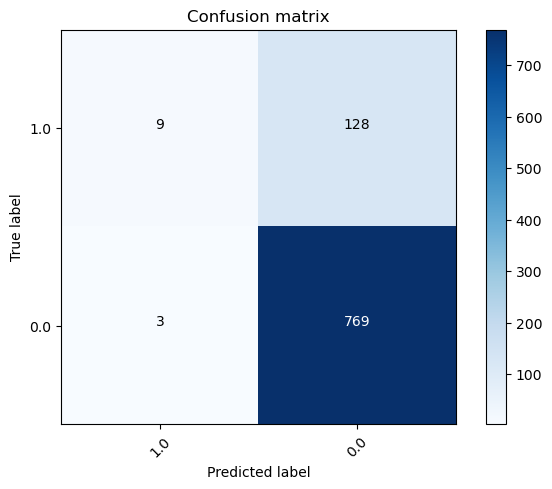

In [39]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [40]:
test_data.groupBy('TenYearCHD').count().show()

+----------+-----+
|TenYearCHD|count|
+----------+-----+
|       0.0|  772|
|       1.0|  137|
+----------+-----+



In [36]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 529.8 kB/s eta 0:00:0000:0100:01
